# Example 07: Training Callbacks and Data Augmentation

Callbacks let you customize every aspect of the training loop without
modifying model code. Data augmentation transforms add noise or bias to
training data, improving generalization. This example demonstrates both.

## Prerequisites

- [Example 00: Your First Model](00_your_first_model.ipynb)
- [Example 01: Understanding the Data Pipeline](01_data_pipeline.ipynb)
- [Example 02: Simulation](02_simulation.ipynb)
- [Example 04: Benchmark RNN](04_benchmark_rnn.py)

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.learner.callbacks import (
    TimeSeriesRegularizer, GradientClipping, VarySeqLen,
    BatchLossFilter, CB_TruncateSequence,
)
from tsfast.data.transforms import SeqNoiseInjection, SeqBiasInjection
from tsfast.learner.losses import fun_rmse

## Load the Dataset

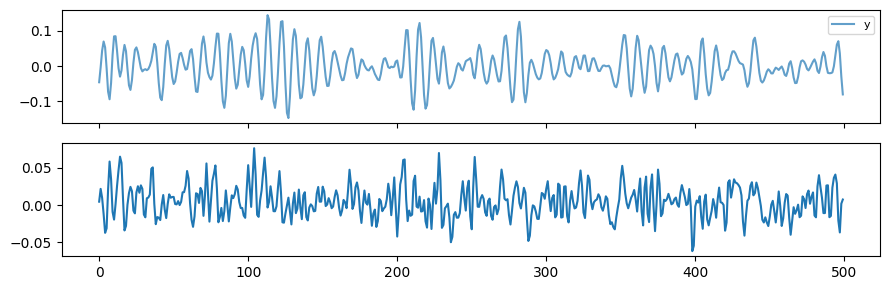

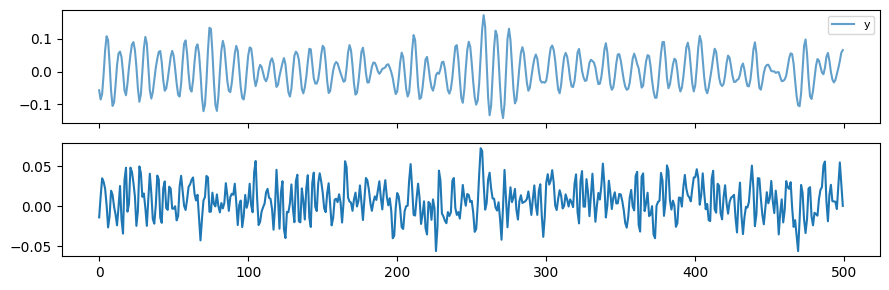

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls.show_batch(max_n=2)

## Data Augmentation Transforms

Transforms modify training data on-the-fly. They only apply during training
(not validation or test), so your evaluation metrics stay comparable.

### SeqNoiseInjection

Adds Gaussian noise to input signals. `std` controls the noise magnitude and
`p` is the probability of applying the transform per batch.

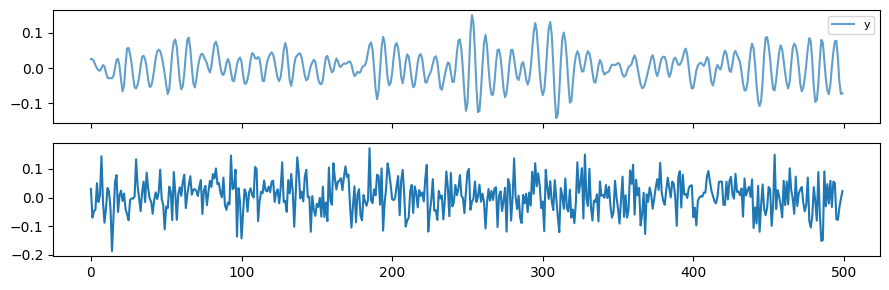

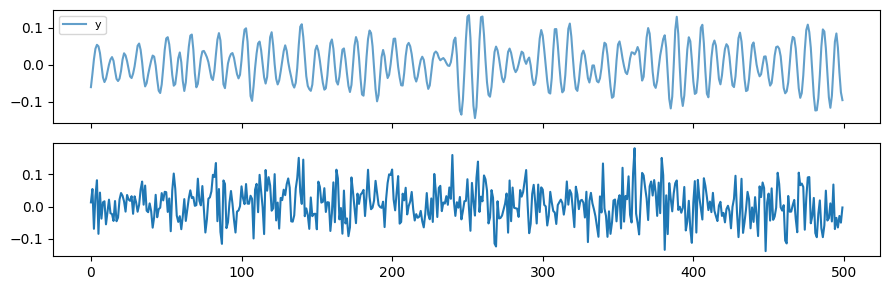

In [3]:
dls_noisy = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls_noisy.train.after_batch.add(SeqNoiseInjection(std=0.05, p=1.0))
dls_noisy.show_batch(max_n=2)

Compare this to the clean batch above -- you should see slight noise on the
input signal.

### SeqBiasInjection

Adds a constant offset per signal per sample. This simulates sensor drift or
calibration errors, making the model more robust to such shifts.

In [4]:
dls_biased = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls_biased.train.after_batch.add(SeqBiasInjection(std=0.1, p=1.0))

### Training with Augmentation

Train two models -- one with augmentation, one without -- to see the effect
on validation performance.

In [5]:
lrn_base = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_base.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"Without augmentation: {lrn_base.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006652,0.004262,0.009694,00:04
1,0.005343,0.005426,0.010370,00:03
2,0.005136,0.004671,0.009939,00:03
3,0.005617,0.004447,0.009885,00:03
4,0.003003,0.002985,0.009474,00:03


Without augmentation: [0.0029846157412976027, 0.009474284015595913]


In [6]:
lrn_aug = RNNLearner(dls_noisy, rnn_type='lstm', metrics=[fun_rmse])
lrn_aug.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"With noise augmentation: {lrn_aug.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.038183,0.030826,0.038482,00:04
1,0.038278,0.032088,0.040164,00:04
2,0.038448,0.034831,0.043489,00:04
3,0.038125,0.030947,0.038781,00:04
4,0.037882,0.032650,0.040802,00:04


With noise augmentation: [0.032649725675582886, 0.040801726281642914]


## TimeSeriesRegularizer

Adds two regularization terms to the loss:

- **`alpha`**: L2 penalty on RNN activations -- prevents activations from
  growing too large.
- **`beta`**: L2 penalty on temporal differences of activations -- encourages
  smooth predictions over time.

`modules` specifies which model components to regularize (typically the RNN
layers).

/home/pheenix/Development/tsfast/.venv/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,fun_rmse,time
0,0.006877,0.005088,0.010489,00:04
1,0.005335,0.005456,0.010513,00:04
2,0.005441,0.004704,0.009978,00:04
3,0.004981,0.005478,0.010341,00:04
4,0.003048,0.003006,0.009582,00:04


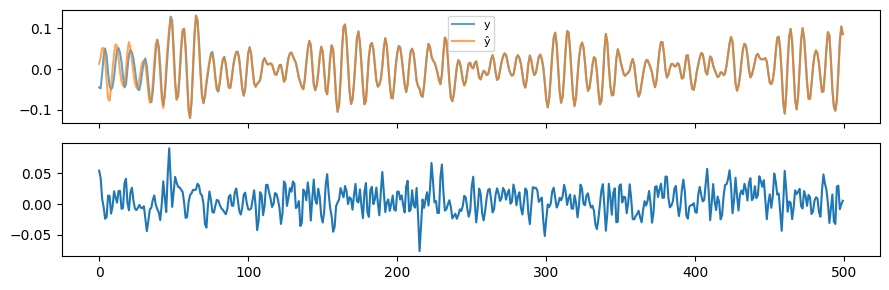

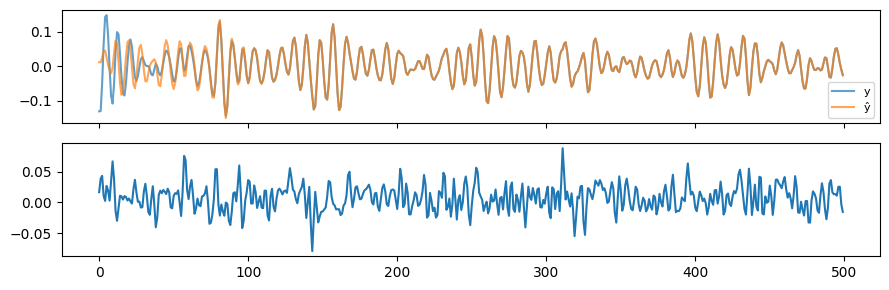

In [7]:
lrn_reg = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_reg.fit_flat_cos(n_epoch=5, lr=3e-3, cbs=[
    TimeSeriesRegularizer(alpha=2.0, beta=1.0)
])
lrn_reg.show_results(max_n=2)

## GradientClipping

Clips the gradient norm during backpropagation. This prevents exploding
gradients, which are common with RNNs on long sequences. `clip_val` is the
maximum allowed gradient norm.

In [8]:
lrn_clip = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_clip.fit_flat_cos(n_epoch=5, lr=3e-3, cbs=[GradientClipping(clip_val=10)])

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006659,0.003822,0.009696,00:04
1,0.005488,0.006986,0.011253,00:04
2,0.005585,0.004701,0.009895,00:03
3,0.004845,0.003329,0.009496,00:03
4,0.002942,0.002981,0.009495,00:03


## VarySeqLen

Randomly truncates sequences to different lengths each batch. This acts as
data augmentation by preventing the model from overfitting to a fixed window
size. `min_len` sets the minimum allowed length.

In [9]:
lrn_vary = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_vary.fit_flat_cos(n_epoch=5, lr=3e-3, cbs=[VarySeqLen(min_len=100)])

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009295,0.010037,0.014312,00:03
1,0.007490,0.004950,0.010134,00:03
2,0.006839,0.004671,0.010101,00:03
3,0.008140,0.005248,0.010482,00:03
4,0.005721,0.003040,0.009572,00:02


## BatchLossFilter

Keeps only the hardest batches (those with the highest loss) for gradient
updates. `loss_perc=0.5` means only the top 50% of samples by loss
contribute to learning -- a form of curriculum learning that focuses on the
most informative examples.

In [10]:
lrn_filter = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_filter.fit_flat_cos(n_epoch=5, lr=3e-3, cbs=[BatchLossFilter(loss_perc=0.5)])

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009731,0.006822,0.011330,00:03
1,0.007746,0.005025,0.010146,00:03
2,0.007213,0.005674,0.010388,00:03
3,0.006757,0.004591,0.009892,00:03
4,0.005277,0.003035,0.009516,00:03


## CB_TruncateSequence

Progressively increases sequence length during training. Starts with short
sequences (easier for the model) and gradually increases to full length.
This is a form of curriculum learning that helps the model learn short-term
dynamics first before tackling longer dependencies.

In [11]:
lrn_trunc = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_trunc.fit_flat_cos(n_epoch=10, lr=3e-3, cbs=[CB_TruncateSequence(truncate_length=100)])

epoch,train_loss,valid_loss,fun_rmse,time
0,0.014284,0.007652,0.012246,00:02
1,0.013533,0.004301,0.009949,00:02
2,0.009241,0.004725,0.010128,00:02
3,0.006236,0.004082,0.009868,00:02
4,0.005766,0.003127,0.009552,00:02
5,0.005081,0.003797,0.009684,00:02
6,0.004554,0.003892,0.009702,00:02
7,0.004898,0.005207,0.010182,00:02
8,0.003430,0.003549,0.009639,00:03
9,0.002815,0.002883,0.009516,00:02


## Combining Callbacks

Multiple callbacks can be combined. They execute in order during each
training step, so you can layer regularization, gradient control, and
curriculum strategies together.

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006778,0.005494,0.010441,00:03
1,0.005572,0.006622,0.010954,00:03
2,0.005327,0.004019,0.009711,00:03
3,0.005206,0.006884,0.011274,00:03
4,0.005619,0.006011,0.010712,00:03
5,0.005245,0.003787,0.009703,00:03
6,0.004629,0.007744,0.011882,00:03
7,0.004425,0.007224,0.011468,00:03
8,0.003759,0.003632,0.009630,00:03
9,0.002792,0.002905,0.009529,00:03


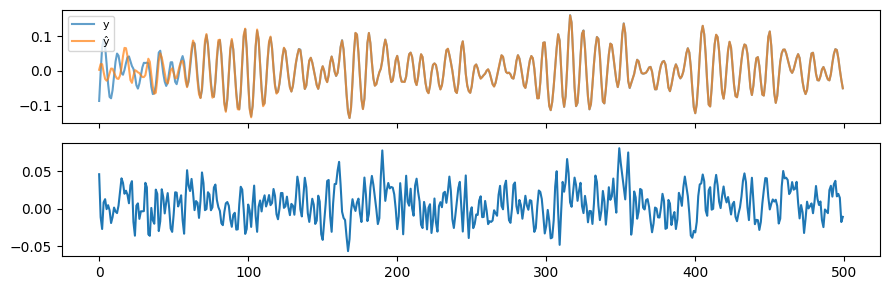

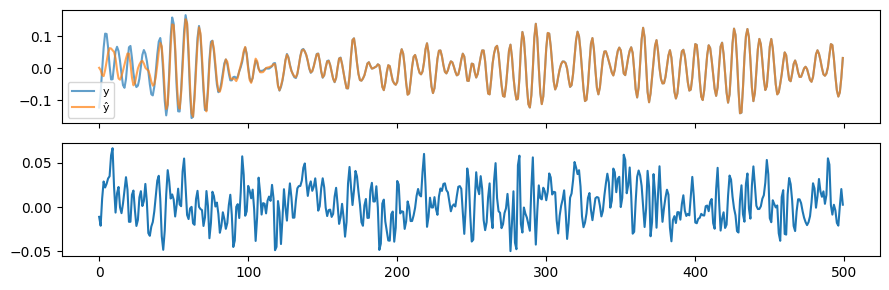

In [12]:
lrn_combined = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_combined.fit_flat_cos(n_epoch=10, lr=3e-3, cbs=[
    TimeSeriesRegularizer(alpha=2.0, beta=1.0),
    GradientClipping(clip_val=10),
])
lrn_combined.show_results(max_n=2)

## Key Takeaways

- **`SeqNoiseInjection`** and **`SeqBiasInjection`** augment training data
  for better generalization.
- **`TimeSeriesRegularizer`** smooths predictions with activation and
  temporal penalties.
- **`GradientClipping`** prevents exploding gradients on long sequences.
- **`VarySeqLen`** acts as augmentation by varying sequence length each
  batch.
- **`BatchLossFilter`** focuses learning on the hardest examples.
- **`CB_TruncateSequence`** implements curriculum learning with progressive
  sequence length.
- Callbacks compose -- combine multiple for best results.